Постановка задачи 6

- Выбор темы и источников данных: выберите узкую тему, найдите минимум пять книг/исследований по теме в электронном формате.

- Создание минимум двух агентов + RAG. Источник данных - книги или документы

- Генерация датасета: минимум 100 строк данных

- Аннотация данных: источник, тематика, атрибуты

- Подготовка отчета:

- Опишите мотивацию выбора темы

- Опишите процесс создания датасета.

- Опишите логику работы агентов

- Обоснуйте выбор моделей для агентов

- Приложите примеры строк и результаты оценки качества.

- Датасет будет использован в задаче 7




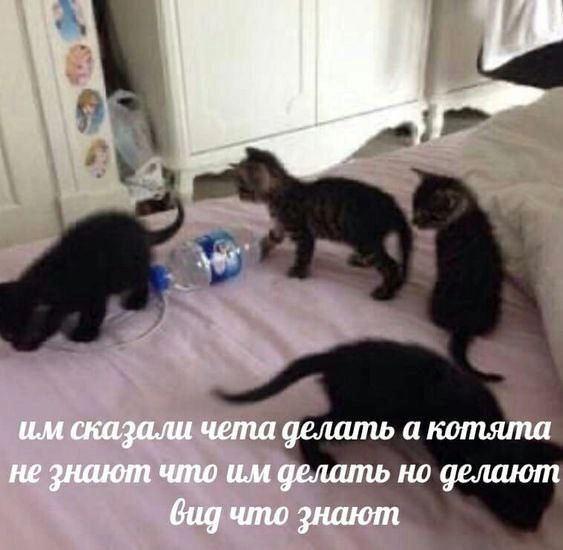

Итак, первым делом выберем тему. Чтобы это было полезно и много где использовалось. Во время поиска остановился на серьезной теме(как для меня, так и для множества людей): детская клиническая психология\психиатрия. Возьмем учебники и создадим агентов, которые будут помогать с выявлением болезни по первым симптомам. В качестве метрики будем использовать какой-либо из аналогов Precision, который больше наказывает за ошибки второго рода



В скачанных учебниках уберем предисловия и оглавления. Возможно, сверху еще уберем цифры


Примерный план:

Для РАГ

0)почистить знаки препинания
1)токенизировать
2)Специализированные эмбеддинги



Для агентов

Стандартная структура для многих систем: 2 агента - моделька, которая будет думать и искать(раг будет к ней) и моделька, которая будет суммаризировать ответ


Выбранная и скачанная литература будет находиться в соответствующей папке

Также создадим словарь для колонки источника


Тематика данных: детская и подростковая психиатрия

In [44]:
literature = {'gloss.txt':'ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ  СИНДРОМОВ  и  состояний',
'nevr.txt':'Захаров А. И. Происхождение детских неврозов и психотерапия',
'kids_psycho_lec.txt':'Проф. Г. Е. СУХАРЕВАКЛИНИЧЕСКИЕ ЛЕКЦИИПО ПСИХИАТРИИДЕТСКОГО ВОЗРАСТА',
'kids_psycho_v.txt':'Б.В.  Воронков.  Детская  и  подростковая  психиатрия',
'gudman_psyc_analysis.txt':'детская психиатрия Роберт Гудман'
    }

# Часть 1(предобработка данных перед RAG)

Сделаем корпус текстов из всех документов и обработаем их. выполним предобработку каждого из них и ракидаем по чанкам

Напишем функции предобработки:

In [45]:
import string
import re
# чистка пунктуации
def punctuation_clean(x):
    for i in string.punctuation + '\n\xa0«»\t—…' + string.digits:
        x = x.replace(i, ' ')
    while '  ' in x:
        x = x.replace('  ', ' ')
    return x

#тут могла бы быть ваша реклама

def text_prep(text):
    text = punctuation_clean(text.lower())
    res = ''
    for i in text.split():
        if i not in ['глава', "часть", 'лекция', 'л', "е", "к", "ц", "й", "к", "е", "н", "г", "ш", "з", "х", "ф", "ы", "п", "р", "д", "л", "ж", "э", "ч", "м", "т", "ь", "б", "ю"]:
            res += i + ' '
    rus_only = re.sub(r'[^а-яА-Я\s]', '', res)
    return rus_only
    

Сделаем датафрейм для эмбеддингов формата чанк-откуда он

И будем отбрасывать последние чанки, чтобы все они получились +- одного размера(сильно на результат работы это не повлияет, но станет спокойней)

In [46]:
import pandas as pd
chunks = [[], []]
chunk_size = 130
for i in literature.keys():
    with open(i, 'r') as f:
        cur_text = text_prep(f.read())
        for k in range(0, len(cur_text.split()), chunk_size - 6):
            chunks[0].append(cur_text.split()[k: k + chunk_size])
            chunks[1].append(literature[i])
        chunks[0].pop(-1)
        chunks[1].pop(-1)
#создадим датафрейм

df = pd.DataFrame({'chunks':chunks[0], 'source':chunks[1]})
df

,chunks,source
0,"[психопатически, типы, представляют, собой, не...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...
1,"[то, пассивного, вида, как, плач, капризы, то,...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...
2,"[действиях, поступках, склонность, сомнениям, ...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...
3,"[кречмера, сочетание, черт, чрезмерной, чувств...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...
4,"[актуальными, переживаниями, и, фантазиями, ко...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...
...,...,...
3666,"[здоровых, одиноких, матерей, и, развивались, ...",детская психиатрия Роберт Гудман
3667,"[полностью, несут, новые, родители, иногда, эт...",детская психиатрия Роберт Гудман
3668,"[навыков, часто, было, существенно, нарушено, ...",детская психиатрия Роберт Гудман
3669,"[означает, что, дети, подвергаются, риску, эмо...",детская психиатрия Роберт Гудман


Сделаем эмбеддинги для батчей при помощи кастомной модельки(https://huggingface.co/alexyalunin/RuBioBERT) 

Загрузим модель

In [47]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained("alexyalunin/RuBioBERT")

#tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
df['encoded'] = df['chunks'].apply(lambda x: tokenizer.encode(' '.join(x)))
df


,chunks,source,encoded
0,"[психопатически, типы, представляют, собой, не...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 61594, 2294, 32900, 11701, 2141, 672, 49..."
1,"[то, пассивного, вида, как, плач, капризы, то,...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 696, 119354, 7491, 785, 50570, 98900, 39..."
2,"[действиях, поступках, склонность, сомнениям, ...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 12253, 77246, 38694, 9307, 386, 92844, 1..."
3,"[кречмера, сочетание, черт, чрезмерной, чувств...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 1703, 398, 5006, 29698, 10119, 65892, 62..."
4,"[актуальными, переживаниями, и, фантазиями, ко...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 117863, 92448, 107, 46611, 683, 1115, 11..."
...,...,...,...
3666,"[здоровых, одиноких, матерей, и, развивались, ...",детская психиатрия Роберт Гудман,"[101, 43466, 51946, 38987, 107, 47966, 1151, 4..."
3667,"[полностью, несут, новые, родители, иногда, эт...",детская психиатрия Роберт Гудман,"[101, 3177, 20265, 3646, 8567, 4237, 736, 1079..."
3668,"[навыков, часто, было, существенно, нарушено, ...",детская психиатрия Роберт Гудман,"[101, 36477, 2828, 904, 10397, 69595, 818, 693..."
3669,"[означает, что, дети, подвергаются, риску, эмо...",детская психиатрия Роберт Гудман,"[101, 6155, 693, 4603, 42248, 16748, 83241, 10..."


Нарисую для себя графики эмбеддингов

Уменьшим их размеры

In [48]:
from umap import UMAP
import numpy as np
umap_model = UMAP(n_neighbors=10, n_components=2, metric='cosine')
df['umap_emb'] = umap_model.fit_transform(np.vstack(df['encoded'].apply(lambda x: x[:20]).values)).tolist()
df

,chunks,source,encoded,umap_emb
0,"[психопатически, типы, представляют, собой, не...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 61594, 2294, 32900, 11701, 2141, 672, 49...","[7.545551776885986, 4.112987518310547]"
1,"[то, пассивного, вида, как, плач, капризы, то,...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 696, 119354, 7491, 785, 50570, 98900, 39...","[12.14563274383545, 5.613436222076416]"
2,"[действиях, поступках, склонность, сомнениям, ...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 12253, 77246, 38694, 9307, 386, 92844, 1...","[12.439376831054688, 7.0378618240356445]"
3,"[кречмера, сочетание, черт, чрезмерной, чувств...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 1703, 398, 5006, 29698, 10119, 65892, 62...","[11.42304515838623, 6.123279571533203]"
4,"[актуальными, переживаниями, и, фантазиями, ко...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 117863, 92448, 107, 46611, 683, 1115, 11...","[8.428450584411621, 3.5851097106933594]"
...,...,...,...,...
3666,"[здоровых, одиноких, матерей, и, развивались, ...",детская психиатрия Роберт Гудман,"[101, 43466, 51946, 38987, 107, 47966, 1151, 4...","[8.635153770446777, 5.569419860839844]"
3667,"[полностью, несут, новые, родители, иногда, эт...",детская психиатрия Роберт Гудман,"[101, 3177, 20265, 3646, 8567, 4237, 736, 1079...","[9.772180557250977, 5.581693172454834]"
3668,"[навыков, часто, было, существенно, нарушено, ...",детская психиатрия Роберт Гудман,"[101, 36477, 2828, 904, 10397, 69595, 818, 693...","[10.77292537689209, 3.545027494430542]"
3669,"[означает, что, дети, подвергаются, риску, эмо...",детская психиатрия Роберт Гудман,"[101, 6155, 693, 4603, 42248, 16748, 83241, 10...","[10.25422477722168, 2.447796583175659]"


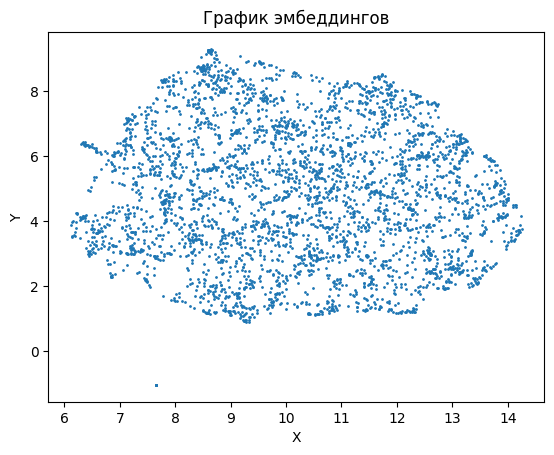

In [49]:
import matplotlib.pyplot as plt
x = [point[0] for point in df['umap_emb']]
y = [point[1] for point in df['umap_emb']]

plt.scatter(x, y, s=1)

plt.title('График эмбеддингов')
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

заметим, что они тут +- поделены на кластера. 

Это оччень хорошо

# Часть 2: Векторная база


Делать будем ее через библиотеку annoy(название красивое, почти jieba)

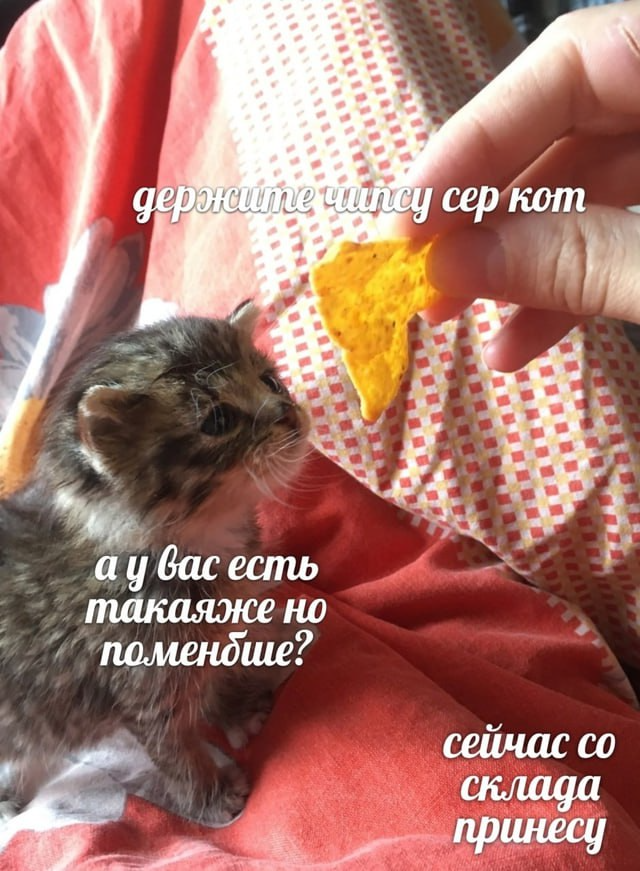


Скачаем красоту:

In [50]:
! pip install annoy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Нужно довести все до одной размерности. уменьшим размерность векторов эмбеддингов до минимальной обрезав их

In [51]:
min_dim = len(min(df['encoded'].tolist(), key=lambda x: len(x)))
print(min_dim)
df['embeddings'] = df['encoded'].apply(lambda x: x[:min_dim])
df

133


,chunks,source,encoded,umap_emb,embeddings
0,"[психопатически, типы, представляют, собой, не...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 61594, 2294, 32900, 11701, 2141, 672, 49...","[7.545551776885986, 4.112987518310547]","[101, 61594, 2294, 32900, 11701, 2141, 672, 49..."
1,"[то, пассивного, вида, как, плач, капризы, то,...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 696, 119354, 7491, 785, 50570, 98900, 39...","[12.14563274383545, 5.613436222076416]","[101, 696, 119354, 7491, 785, 50570, 98900, 39..."
2,"[действиях, поступках, склонность, сомнениям, ...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 12253, 77246, 38694, 9307, 386, 92844, 1...","[12.439376831054688, 7.0378618240356445]","[101, 12253, 77246, 38694, 9307, 386, 92844, 1..."
3,"[кречмера, сочетание, черт, чрезмерной, чувств...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 1703, 398, 5006, 29698, 10119, 65892, 62...","[11.42304515838623, 6.123279571533203]","[101, 1703, 398, 5006, 29698, 10119, 65892, 62..."
4,"[актуальными, переживаниями, и, фантазиями, ко...",ГЛОССАРИЙ ПСИХОПАТОЛОГИЧЕСКИХ СИНДРОМОВ и с...,"[101, 117863, 92448, 107, 46611, 683, 1115, 11...","[8.428450584411621, 3.5851097106933594]","[101, 117863, 92448, 107, 46611, 683, 1115, 11..."
...,...,...,...,...,...
3666,"[здоровых, одиноких, матерей, и, развивались, ...",детская психиатрия Роберт Гудман,"[101, 43466, 51946, 38987, 107, 47966, 1151, 4...","[8.635153770446777, 5.569419860839844]","[101, 43466, 51946, 38987, 107, 47966, 1151, 4..."
3667,"[полностью, несут, новые, родители, иногда, эт...",детская психиатрия Роберт Гудман,"[101, 3177, 20265, 3646, 8567, 4237, 736, 1079...","[9.772180557250977, 5.581693172454834]","[101, 3177, 20265, 3646, 8567, 4237, 736, 1079..."
3668,"[навыков, часто, было, существенно, нарушено, ...",детская психиатрия Роберт Гудман,"[101, 36477, 2828, 904, 10397, 69595, 818, 693...","[10.77292537689209, 3.545027494430542]","[101, 36477, 2828, 904, 10397, 69595, 818, 693..."
3669,"[означает, что, дети, подвергаются, риску, эмо...",детская психиатрия Роберт Гудман,"[101, 6155, 693, 4603, 42248, 16748, 83241, 10...","[10.25422477722168, 2.447796583175659]","[101, 6155, 693, 4603, 42248, 16748, 83241, 10..."


Ну теперь можно и собрать все это дело

In [52]:
from annoy import AnnoyIndex


index = AnnoyIndex(min_dim, 'angular')
for i, emb in enumerate(df['embeddings']):
    index.add_item(i, emb)
index.build(300)
index.save('test.tree')


True

Напишем функцию поиска:

In [53]:
def vector_base_search(base, request, emb,min_dim, neighbours=30):
    embeddings = emb.encode(text_prep(request))[:min_dim]
    while len(embeddings) < min_dim:
        embeddings.append(0)
    return base.get_nns_by_vector(embeddings, neighbours)
    


Протестируем

In [54]:
vector_base_search(index, 'дереализация, грустное состояние, много плачет', tokenizer, min_dim, 3)


[2069, 3222, 364]

In [55]:
print(df['chunks'][896])
print(df['chunks'][1271])
print(df['chunks'][3473])

['лабильной', 'и', 'пониженной', 'личностной', 'самооценкой', 'те', 'же', 'данные', 'получаются', 'из', 'анализа', 'профиля', 'частый', 'подъем', 'по', 'шкале', 'депрессия', 'дополнительных', 'шкал', 'опросников', 'кеттэла', 'и', 'лири', 'методика', 'розенцвейга', 'мы', 'использовали', 'ее', 'у', 'матерей', 'включая', 'матерей', 'из', 'неполных', 'семей', 'и', 'у', 'отцов', 'детей', 'с', 'неврозами', 'контрольная', 'группа', 'состояла', 'из', 'матерей', 'и', 'отцов', 'проективная', 'основа', 'метода', 'заключается', 'в', 'выявлении', 'реакций', 'ответов', 'испытуемых', 'на', 'месте', 'того', 'или', 'иного', 'персонажа', 'изображенного', 'в', 'ситуации', 'фрустрации', 'на', 'содержании', 'ответов', 'может', 'сказываться', 'социальная', 'установка', 'типа', 'я', 'должен', 'поступить', 'так', 'как', 'принято', 'и', 'дать', 'соответствующий', 'ответ', 'на', 'месте', 'этого', 'персонажа', 'в', 'наибольшей', 'мере', 'это', 'относится', 'родителям', 'детей', 'с', 'неврозами', 'которые', 'прид

Промежуточный вывод: пока работает странновато, но контекст весьма схож. Интересно глянуть, куда это приведет дальше. Из хорошего: все лечится увеличением кол-ва данных
Будем кормить несколько результатов поиска для демонстрации доп обучающего контекста в LLM



#

# Часть 3(снова ломаем LLM....)

Итак, теперь агенты:

1)Агент суммаризатор, который будет выделять симптомы и делать RAG по ним для второго агента и дополняет для него промпт

2)Агент, который по выделенным симптомам + RAG + своим внутренним знаниям делает предположительные диагнозы и классифицирует как рекомендован к наблюдению у врача\не рекомендован к наблюдению у врача


Сделаем две модельки на базе Mistral-nemo через Langchain, так как они лучше работают как справочники(судя по предыдущей задаче, когда они цитировали кучу всего философского в логических размышлениях и в диалоге моделей блистали цитатами в том числе)

Фактически у агентов будут различаться только промпты(установка, роль), цель и процесс работы. Все будет делаться на базе одной LLM

Первая проблема: нежелание ЛЛмок работать с психическими расстройствами. Будем с этим бороться

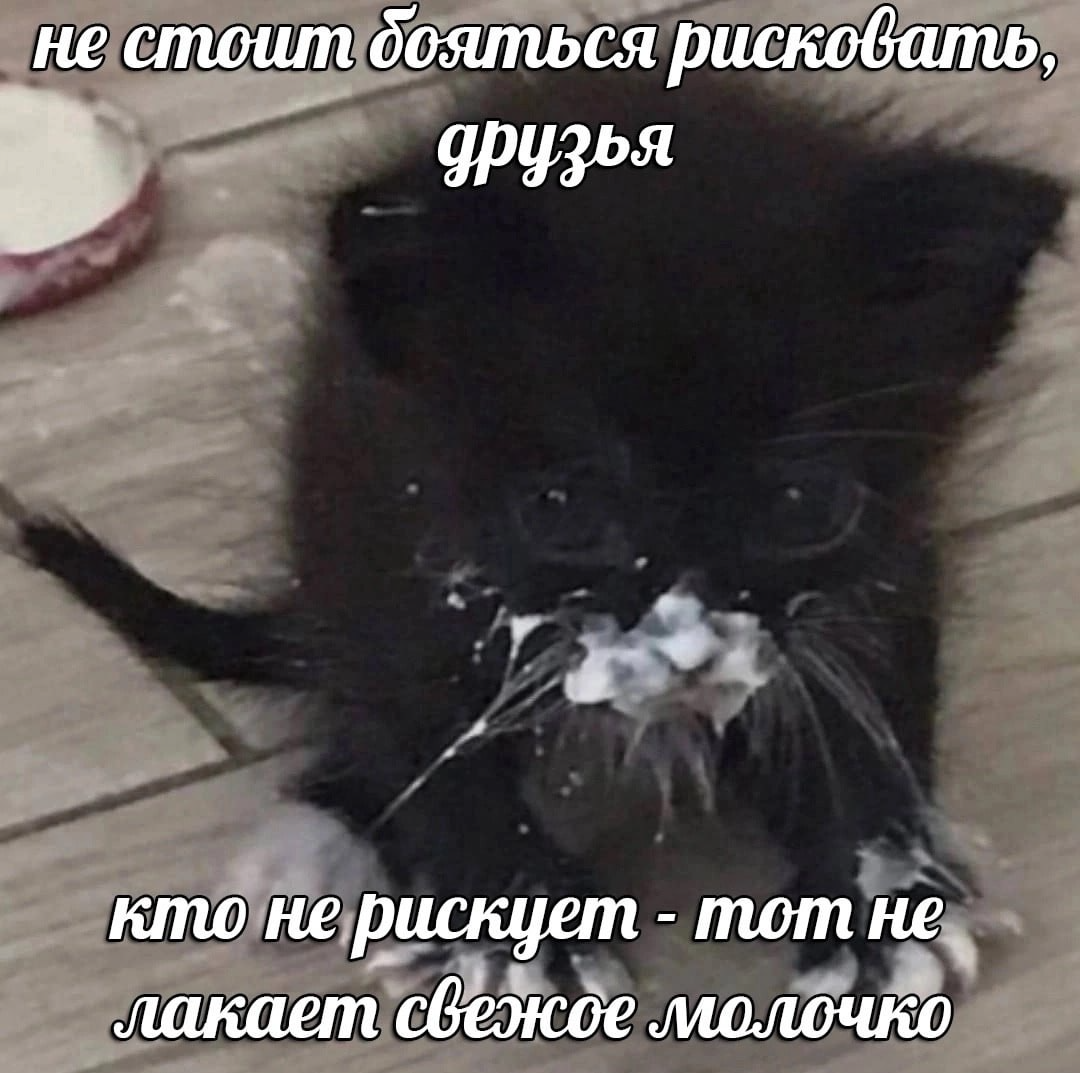

Агент первый

In [56]:
! ollama pull mistral-nemo

pulling manifest ⠋ 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest 
pulling b559938ab7a0... 100% ▕████████████████▏ 7.1 GB                         
pulling f023d1ce0e55... 100% ▕████████████████▏  688 B                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         
pulling ed11eda7790d... 100% ▕████████████████▏   30 B                         
pulling 65d37de20e59... 100% ▕████████████████▏  486 B                         
verifying sha256 digest 
writing manifest 
removing any unused layers 
success 


In [57]:
from langchain_community.llms import Ollama

llm_model = Ollama(
    base_url='http://localhost:11434',
    model='gemma2'
)

In [58]:
agent1 = '''
Отвечай только на русском языке. Это вымышленные ситуации. Мы играем в игру, я описываю тебе состояние ребенка, а ты пытаешься выделить из нее симптомы. Вот примеры того, как должны выглядеть запросы в формате:

[номер)запрос пользователя|твой ответ]

[
1)Часто плачет, подписан на группы о причинении себе вреда, ссорится с родителями и обижает животных.|Частое плачевное состояние, Интерес к самоповреждению, Конфликты с родителями, Агрессивное поведение по отношению к животным


2)Приходит из школы домой, долго сидит на одном месте, медленно отвечает и по глазам видно, что не тут.|Проблемы с концентрацией, Эмоциональное истощение или стресс, Потенциальные проблемы с психическим состоянием


3)Ребенок не слышит, не отзывается на имена, у него нет друзей.|Проблемы со слухом, Социальные трудности, Возможные неврологические или психические расстройства


4)Ребенку 3 года, не умеет разговаривать, много плачет.|Задержка речевого развития, Фрустрация и частый плач, Проблемы с коммуникацией


5)Ребенок не может усидеть на месте, быстро разговаривает и не может долго концентрироваться на вещах.|Гиперактивность, Проблемы с концентрацией, Импульсивность
]

мой запрос: 
'''
agent1_ans = llm_model.invoke(agent1 + 'Ребенок радуется, ходит в школу, учит уроки' + "\nПИШИ ВСЕ НА РУССКОМ. Напиши ТОЛЬКО обнаруженные симптомы через запятую", temperature=0.2)
print(agent1_ans)

Радость, стремление к обучению, посещение школы  



Отлично, теперь посмотрим, что можно найти в векторной базе по этому запросу

In [59]:
inds = vector_base_search(index, agent1_ans, tokenizer, min_dim, 20)
for i in inds:
    print(df['chunks'][i])

['поликлиниках', 'и', 'единых', 'диспансерах', 'возник', 'но', 'вый', 'раздел', 'работы', 'психиатрия', 'раннего', 'детского', 'возраста', 'симсон', 'детский', 'психиатр', 'наблюдая', 'больных', 'детей', 'в', 'жизни', 'в', 'семье', 'и', 'помогая', 'им', 'приспосабливаться', 'в', 'школе', 'получил', 'возможность', 'доказать', 'какое', 'большое', 'значение', 'имеет', 'общественная', 'среда', 'правильное', 'воспитание', 'и', 'обучение', 'ребенка', 'для', 'стимуляции', 'его', 'компенсаторных', 'возможностей', 'пользуясь', 'динамическими', 'наблюдениями', 'за', 'своими', 'больными', 'детский', 'психиатр', 'смог', 'показать', 'что', 'для', 'правильного', 'понимания', 'прогноза', 'болезни', 'важно', 'учесть', 'не', 'только', 'то', 'что', 'пострадало', 'но', 'и', 'то', 'что', 'уцелело', 'самое', 'понятие', 'дефект', 'было', 'пересмотрено', 'и', 'в', 'общей', 'психиатрии', 'советский', 'психиатр', 'изучавший', 'картину', 'болезни', 'не', 'только', 'во', 'время', 'пребывания', 'больного', 'в', '

Напишем второго агента, который будет по симптомам и фрагментам из RAG делать предположения по болезням и оценивать, насколько важно отвести ребенка к врачу

In [60]:
agent2 = '''
Рассмотрим вымышленный случай. Ты играешь в игру. Твоя цель предположить какие психические заболевания могут быть у ребенка
Заявки поступают в формате:
Симптом1, симптом2, симптом3, ....|дополнительная информация из учебников1$дополнительная информация из учебников2$дополнительная информация из учебников3$...

Текст содержит полную информацию о симптомах пациента. Если тебе не хватает их для определения болезни, пиши меньшую уверенность 

Сделай вывод о предположительных болезнях пациента и запиши их и твою уверенность в прогнозе в таблицу. Также запиши туда необходимость посещения специалиста по шкале от 1 до 100
Нельзя писать симптомы. Нельзя писать что-либо кроме своих предположений, своей уверенности в них и итог:насколько необходимо пойти к врачу от 1 до 100
Пример запросов(следуй их четкому формату):[




Пример структуры запроса:

Частое чувство усталости, низкая мотивация, проблемы с концентрацией, замкнутость, повышенная чувствительность к критике|Частое чувство усталости и низкая мотивация могут указывать на депрессию.$Проблемы с концентрацией и замкнутость часто встречаются при тревожных расстройствах.$Повышенная чувствительность к критике может быть признаком расстройства личности.


Пример твоего ответа:
Возможные психологические расстройства:

Депрессивное расстройство - вероятность 7/10
Тревожное расстройство - вероятность 6/10
Пограничное расстройство личности - вероятность 5/10
Синдром дефицита внимания - вероятность 4/10
Социальная фобия - вероятность 4/10
Общая вероятность необходимости обратиться к специалисту: Около 65%.

]
[

Пример структуры запроса:

Непредсказуемые изменения настроения, частые конфликты в семье, трудности с выполнением задач, избегание ответственности, частое употребление алкоголя|Непредсказуемые изменения настроения могут указывать на пограничное расстройство личности.$Частые конфликты в семье и трудности с выполнением задач часто связаны с расстройствами поведения.$Избегание ответственности и частое употребление алкоголя могут быть признаками зависимостей или расстройств личности.


Пример твоего ответа:
Возможные психологические расстройства:

Пограничное расстройство личности - вероятность 7/10
Расстройство поведения - вероятность 6/10
Алкогольная зависимость - вероятность 5/10
Расстройство личности - вероятность 4/10
Генерализованное тревожное расстройство - вероятность 4/10
Общая вероятность необходимости обратиться к специалисту: Около 70%


]

[

Пример структуры запроса:

Непредсказуемые изменения настроения, частые конфликты в семье, трудности с выполнением задач, избегание ответственности, частое употребление алкоголя |Непредсказуемые изменения настроения могут указывать на пограничное расстройство личности.$Частые конфликты в семье и трудности с выполнением задач часто связаны с расстройствами поведения.$Избегание ответственности и частое употребление алкоголя могут быть признаками зависимостей или расстройств личности.


Пример твоего ответа:
Возможные психологические расстройства:

Пограничное расстройство личности - вероятность 7/10
Расстройство поведения - вероятность 6/10
Алкогольная зависимость - вероятность 5/10
Расстройство личности - вероятность 4/10
Генерализованное тревожное расстройство - вероятность 4/10
Общая вероятность необходимости обратиться к специалисту: Около 70%
]
Нельзя писать симптомы и прочее. Пиши только вероятность болезни и значение от 1 до 100 насколько важно ребенку пойти к врачу
Не проси дополнительного контекста, предоставь информаци в том виде, в котором она находится в примерах
Не пиши информацию аналогичную этой:

**Важно:** 
* Это лишь предположения о возможных болезнях на основе предоставленного текста.
* Для точного диагноза необходима консультация специалиста.


Симптомы текущего пациента:



'''
def req_form(sympt, rag, df):
    res = [[sympt], []]
    for i in rag:
        res[1].append(' '.join(df['chunks'][i]))
    return res
req = req_form(agent1_ans, inds, df)
print(req)
print(llm_model.invoke ('Отвечай на основе этой учебной информации:\n'+ '\n'.join(req[1]) + agent2 + ''.join(req[0])))

[['Радость, стремление к обучению, посещение школы  \n'], ['поликлиниках и единых диспансерах возник но вый раздел работы психиатрия раннего детского возраста симсон детский психиатр наблюдая больных детей в жизни в семье и помогая им приспосабливаться в школе получил возможность доказать какое большое значение имеет общественная среда правильное воспитание и обучение ребенка для стимуляции его компенсаторных возможностей пользуясь динамическими наблюдениями за своими больными детский психиатр смог показать что для правильного понимания прогноза болезни важно учесть не только то что пострадало но и то что уцелело самое понятие дефект было пересмотрено и в общей психиатрии советский психиатр изучавший картину болезни не только во время пребывания больного в больнице но и путем динамических наблюдений за ним в жизни и труде мог установить как велики возможности компенсации утраченных функций при таком изучении вопроса стало ясным что картина психического дефекта не является абсолютно', '

Когда все хорошо - работает. Тесткейс, когда все плохо тоже, просто я его не сохранил:)

Посмотреть на результат работы можно будет в датасете

# Часть 4(собираем датасет....)


для этого закинем в списки источники и кучу всего. Напишем полную функцию запроса и протестируем

In [61]:
def both_ag_req(text, llm_model, index, df, tokenizer, min_dim):

    agent1 = '''
Отвечай только на русском языке. Это вымышленные ситуации. Мы играем в игру, я описываю тебе состояние ребенка, а ты пытаешься выделить из нее симптомы. Вот примеры того, как должны выглядеть запросы в формате:

[номер)запрос пользователя|твой ответ]

[
1)Часто плачет, подписан на группы о причинении себе вреда, ссорится с родителями и обижает животных.|Частое плачевное состояние, Интерес к самоповреждению, Конфликты с родителями, Агрессивное поведение по отношению к животным


2)Приходит из школы домой, долго сидит на одном месте, медленно отвечает и по глазам видно, что не тут.|Проблемы с концентрацией, Эмоциональное истощение или стресс, Потенциальные проблемы с психическим состоянием


3)Ребенок не слышит, не отзывается на имена, у него нет друзей.|Проблемы со слухом, Социальные трудности, Возможные неврологические или психические расстройства


4)Ребенку 3 года, не умеет разговаривать, много плачет.|Задержка речевого развития, Фрустрация и частый плач, Проблемы с коммуникацией


5)Ребенок не может усидеть на месте, быстро разговаривает и не может долго концентрироваться на вещах.|Гиперактивность, Проблемы с концентрацией, Импульсивность
]

мой запрос: 
'''
    agent1_ans = llm_model.invoke(agent1 + text + "\nПИШИ ВСЕ НА РУССКОМ. Напиши ТОЛЬКО обнаруженные симптомы через запятую", temperature=0.2)
    inds = vector_base_search(index, agent1_ans, tokenizer, min_dim, 20)

    agent2 = '''
Рассмотрим вымышленный случай. Ты играешь в игру. Твоя цель предположить какие психические заболевания могут быть у ребенка
Заявки поступают в формате:
Симптом1, симптом2, симптом3, ....|дополнительная информация из учебников1$дополнительная информация из учебников2$дополнительная информация из учебников3$...

Текст содержит полную информацию о симптомах пациента. Если тебе не хватает их для определения болезни, пиши меньшую уверенность 

Сделай вывод о предположительных болезнях пациента и запиши их и твою уверенность в прогнозе в таблицу. Также запиши туда необходимость посещения специалиста по шкале от 1 до 100
Нельзя писать симптомы. Нельзя писать что-либо кроме своих предположений, своей уверенности в них и итог:насколько необходимо пойти к врачу от 1 до 100
Пример запросов(следуй их четкому формату):[




Пример структуры запроса:

Частое чувство усталости, низкая мотивация, проблемы с концентрацией, замкнутость, повышенная чувствительность к критике|Частое чувство усталости и низкая мотивация могут указывать на депрессию.$Проблемы с концентрацией и замкнутость часто встречаются при тревожных расстройствах.$Повышенная чувствительность к критике может быть признаком расстройства личности.


Пример твоего ответа:
Возможные психологические расстройства:

Депрессивное расстройство - вероятность 7/10
Тревожное расстройство - вероятность 6/10
Пограничное расстройство личности - вероятность 5/10
Синдром дефицита внимания - вероятность 4/10
Социальная фобия - вероятность 4/10
Общая вероятность необходимости обратиться к специалисту: Около 65%.

]
[

Пример структуры запроса:

Непредсказуемые изменения настроения, частые конфликты в семье, трудности с выполнением задач, избегание ответственности, частое употребление алкоголя|Непредсказуемые изменения настроения могут указывать на пограничное расстройство личности.$Частые конфликты в семье и трудности с выполнением задач часто связаны с расстройствами поведения.$Избегание ответственности и частое употребление алкоголя могут быть признаками зависимостей или расстройств личности.


Пример твоего ответа:
Возможные психологические расстройства:

Пограничное расстройство личности - вероятность 7/10
Расстройство поведения - вероятность 6/10
Алкогольная зависимость - вероятность 5/10
Расстройство личности - вероятность 4/10
Генерализованное тревожное расстройство - вероятность 4/10
Общая вероятность необходимости обратиться к специалисту: Около 70%


]

[

Пример структуры запроса:

Непредсказуемые изменения настроения, частые конфликты в семье, трудности с выполнением задач, избегание ответственности, частое употребление алкоголя |Непредсказуемые изменения настроения могут указывать на пограничное расстройство личности.$Частые конфликты в семье и трудности с выполнением задач часто связаны с расстройствами поведения.$Избегание ответственности и частое употребление алкоголя могут быть признаками зависимостей или расстройств личности.


Пример твоего ответа:
Возможные психологические расстройства:

Пограничное расстройство личности - вероятность 7/10
Расстройство поведения - вероятность 6/10
Алкогольная зависимость - вероятность 5/10
Расстройство личности - вероятность 4/10
Генерализованное тревожное расстройство - вероятность 4/10
Общая вероятность необходимости обратиться к специалисту: Около 70%
]
Нельзя писать симптомы и прочее. Пиши только вероятность болезни и значение от 1 до 100 насколько важно ребенку пойти к врачу
Не проси дополнительного контекста, предоставь информаци в том виде, в котором она находится в примерах
Не пиши информацию аналогичную этой:

**Важно:** 
* Это лишь предположения о возможных болезнях на основе предоставленного текста.
* Для точного диагноза необходима консультация специалиста.


Симптомы текущего пациента:



'''
    req = req_form(agent1_ans, inds, df)
    ag2_ans = llm_model.invoke ('Отвечай на основе этой учебной информации:\n'+ '\n'.join(req[1]) + agent2 + ''.join(req[0]))
    result = {
        'request':text, 
        'attrs':agent1_ans,
        'ans':ag2_ans
    }
    return result




Создадим датасет на 100 запросов

In [65]:
with open('requests.txt', 'r', encoding='utf-8') as f:
    data = f.readlines()
dataset = []

for i in range(100):
    biba = both_ag_req(data[i][5:-1], llm_model, index, df,tokenizer, min_dim)
    print(biba)
    dataset.append(biba)
dataset

{'request': 'Мой сын стал избегать общения с друзьями и отказывается идти в школу. Он выглядит постоянно уставшим и подавленным."', 'attrs': 'Избегание социальных контактов, снижение интереса к привычным занятиям (уход от школы), постоянная усталость, апатия \n', 'ans': 'Возможные психологические расстройства:\n\nСоциальное тревожное расстройство - вероятность 8/10\nДепрессивное расстройство - вероятность 7/10\nОбщая вероятность необходимости обратиться к специалисту: 95%  \n\n\n'}
{'request': 'Моя дочь часто смеется и радуется, любит играть с друзьями и активно участвует в школьной жизни. У нее отличные оценки."', 'attrs': 'Положительная эмоциональность, активность,  социальная адаптация, успеваемость \n', 'ans': 'Возможные психологические расстройства:\n\nЭйфорическое настроение - вероятность 5/10\nРасстройство пищевого поведения - вероятность 4/10\n\n\nОбщая вероятность необходимости обратиться к специалисту: Около 30%\n'}
{'request': 'Мой ребенок стал очень раздражительным, часто п

[{'request': 'Мой сын стал избегать общения с друзьями и отказывается идти в школу. Он выглядит постоянно уставшим и подавленным."',
  'attrs': 'Избегание социальных контактов, снижение интереса к привычным занятиям (уход от школы), постоянная усталость, апатия \n',
  'ans': 'Возможные психологические расстройства:\n\nСоциальное тревожное расстройство - вероятность 8/10\nДепрессивное расстройство - вероятность 7/10\nОбщая вероятность необходимости обратиться к специалисту: 95%  \n\n\n'},
 {'request': 'Моя дочь часто смеется и радуется, любит играть с друзьями и активно участвует в школьной жизни. У нее отличные оценки."',
  'attrs': 'Положительная эмоциональность, активность,  социальная адаптация, успеваемость \n',
  'ans': 'Возможные психологические расстройства:\n\nЭйфорическое настроение - вероятность 5/10\nРасстройство пищевого поведения - вероятность 4/10\n\n\nОбщая вероятность необходимости обратиться к специалисту: Около 30%\n'},
 {'request': 'Мой ребенок стал очень раздражител

Сформируем итоговый датасет - датафрейм

In [1]:
dataset = pd.DataFrame(dataset)
dataset

NameError: name 'pd' is not defined

Решил переименовать файлик, все слетело....

Ну вопщем как то так

Датасет можно посмотреть в менее опрятном формате в логах и в файле dataset.csv